In this notebook we will follow the same approach as in LSTM_1, but this time using returns as our target.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input


colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
ticker = 'SPY'
start = '2010-01-01'
end = '2025-01-01'

In [3]:
df = yf.download(ticker, start=start, end=end)
df.columns = [price for price, _ in df.columns]
df['returns'] = df.Close.pct_change()
df = df.dropna()

C:\Users\Owen\AppData\Local\Temp\ipykernel_31420\857682478.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


# Some initial plots

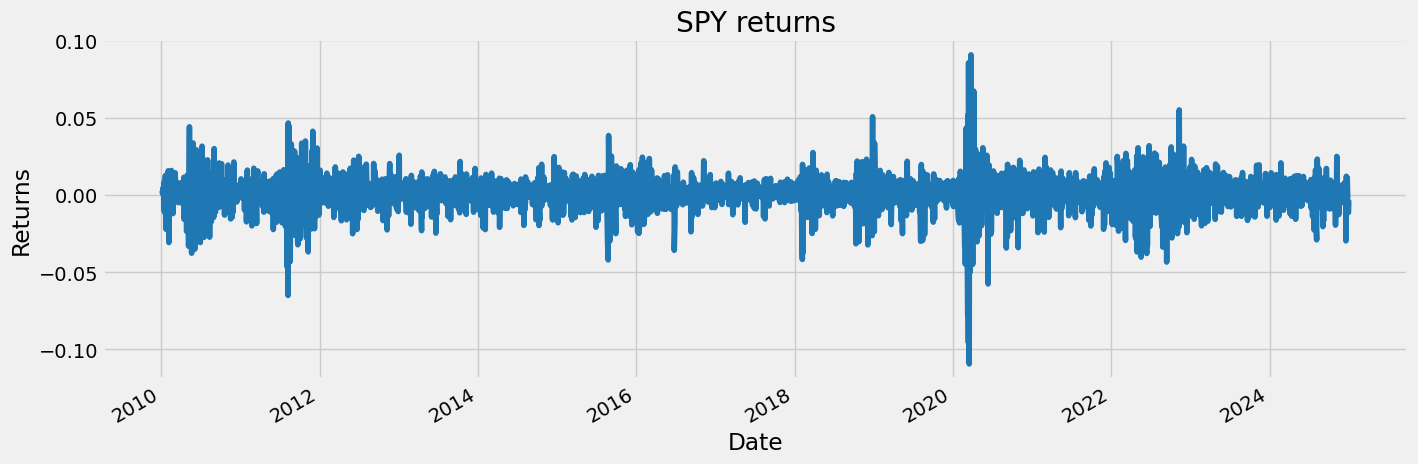

In [10]:
df.returns.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title=f'{ticker} returns', 
              ylabel='Returns')
plt.show()

# Train-test split

In [13]:
date_split = '2023-07-29'

In [15]:
train = df.loc[df.index <= date_split].copy()
test = df.loc[df.index > date_split].copy()

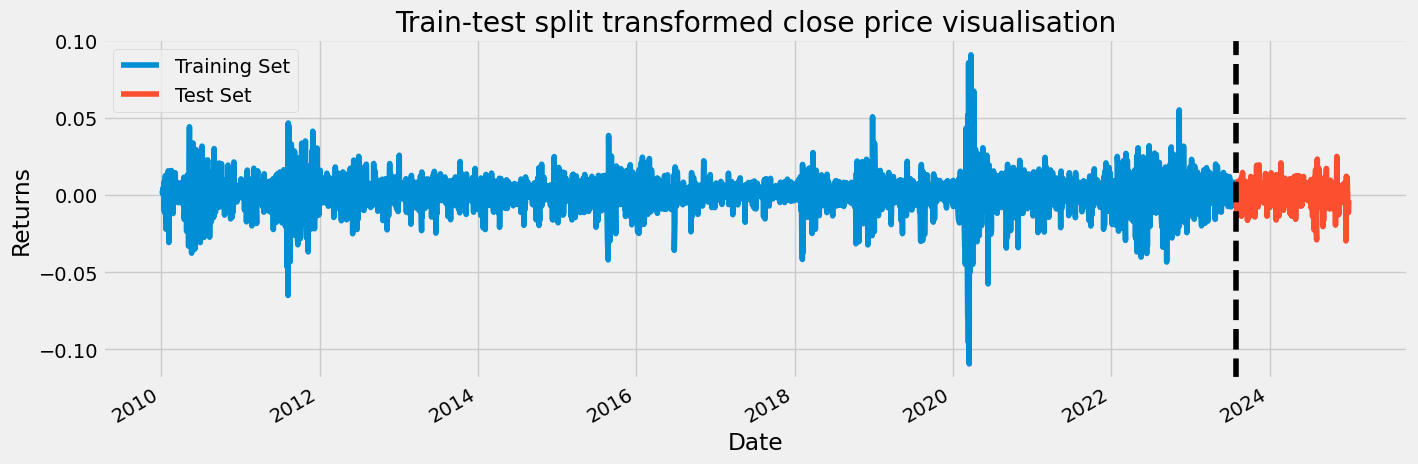

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
train.returns.plot(ax=ax, label='Training Set', title='Train-test split transformed close price visualisation')
test.returns.plot(ax=ax, label='Test Set')
ax.axvline(date_split, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Returns')
plt.show()

In [19]:
X_train = []
y_train = []

for i in range(100, len(train)):
    X_train.append(train.iloc[i-100:i, 5])
    y_train.append(train.iloc[i, 5])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [21]:
X_test = []
y_test = []

for i in range(100, len(test)):
    X_test.append(test.iloc[i-100:i, 5])
    y_test.append(test.iloc[i, 5])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [23]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

In [25]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)

# Build and fit model

In [27]:
model = Sequential()

model.add(Input((X_train.shape[1],1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mae', metrics=[RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,425 (904.00 KB)

 Trainable params: 231,425 (904.00 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_training = model.fit(X_train, y_train, epochs=20, batch_size=64) 

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - loss: 0.6498 - root_mean_squared_error: 0.9707
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 0.6502 - root_mean_squared_error: 0.9722
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 0.6530 - root_mean_squared_error: 0.9796
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - loss: 0.6886 - root_mean_squared_error: 1.0282
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.6736 - root_mean_squared_error: 1.0265
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 0.6772 - root_mean_squared_error: 0.9988
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 0.6622 - root_mean_squared_error: 1.0028
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 0.6619 - root_mean_squared_error: 1.0032
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - loss: 0.6516 - root_mean_squared_error: 0.9917
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - loss: 0.6625 - root_mean_squar

In [31]:
test_preds = model.predict(X_test)
test_preds = y_scaler.inverse_transform(test_preds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


In [33]:
test['predictions'] = np.nan
test.loc[test.index[100]:, 'predictions'] = test_preds.flatten()

In [35]:
train_preds = model.predict(X_train)
train_preds = y_scaler.inverse_transform(train_preds)

104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step


In [36]:
train['predictions'] = np.nan
train.loc[train.index[100]:, 'predictions'] = train_preds.flatten()

# Performance evaluation

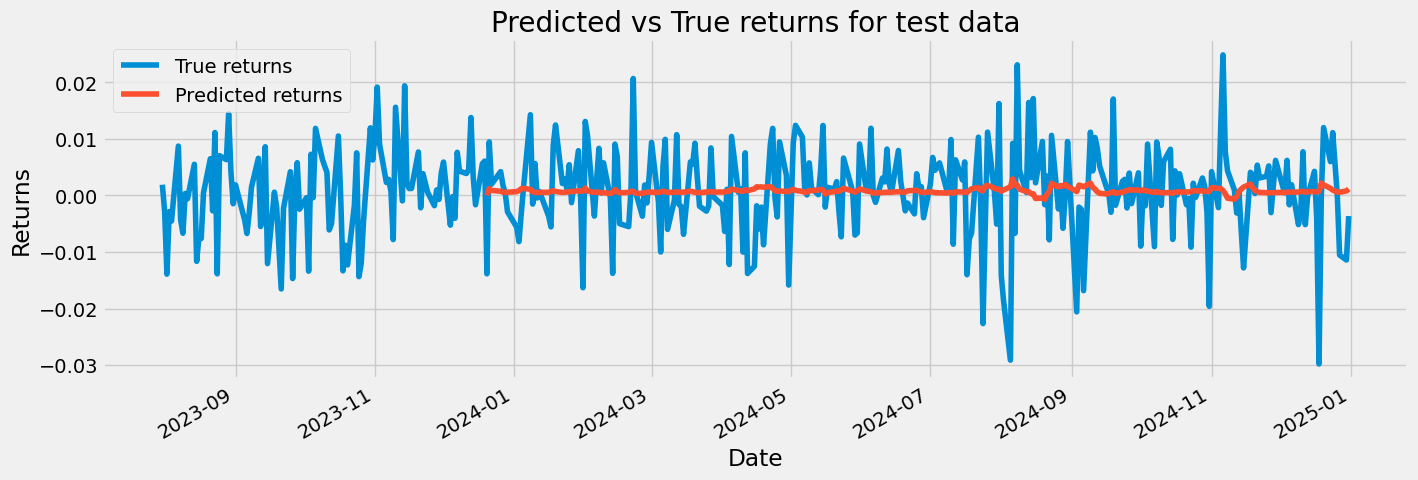

In [39]:
fig, ax = plt.subplots(figsize=(15,5))
test.returns.plot(ax=ax, label='True returns', title='Predicted vs True returns for test data')
test.predictions.plot(ax=ax, label='Predicted returns')
ax.legend()
ax.set_ylabel('Returns')
plt.show()

In [41]:
root_mean_squared_error(y_test, test_preds)

0.007853347416198213

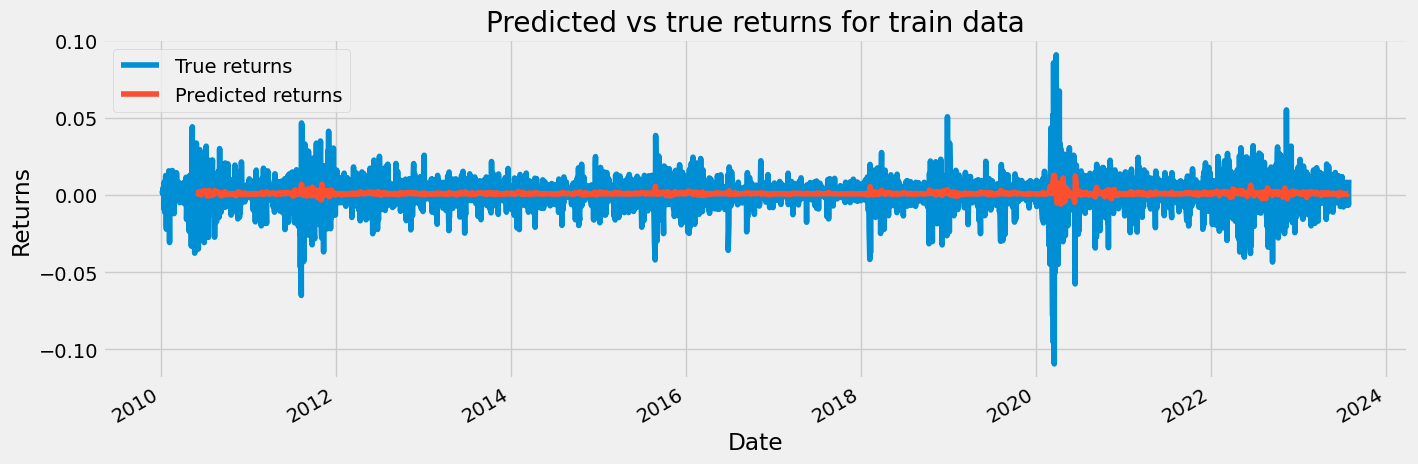

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
train.returns.plot(ax=ax, label='True returns', title='Predicted vs true returns for train data')
train.predictions.plot(ax=ax, label='Predicted returns')
ax.legend()
ax.set_ylabel('Returns')
plt.show()

In [45]:
root_mean_squared_error(y_train, train_preds)

0.9998845764119068

# Implement strategy

In [58]:
tol = 0.000
test['signal'] = test.predictions.apply(lambda x: 1 if x > tol else (-1 if -x > tol else 0))
test['strategy_returns'] = (test.signal * test.returns).cumsum()

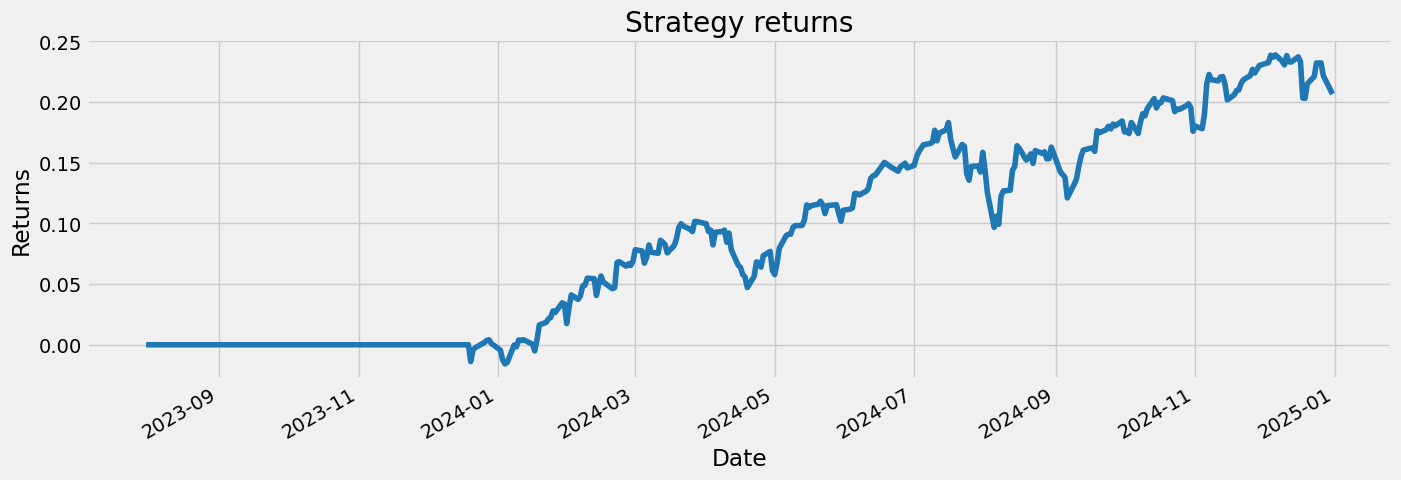

In [60]:
test.strategy_returns.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='Strategy returns', 
              ylabel='Returns')
plt.show()

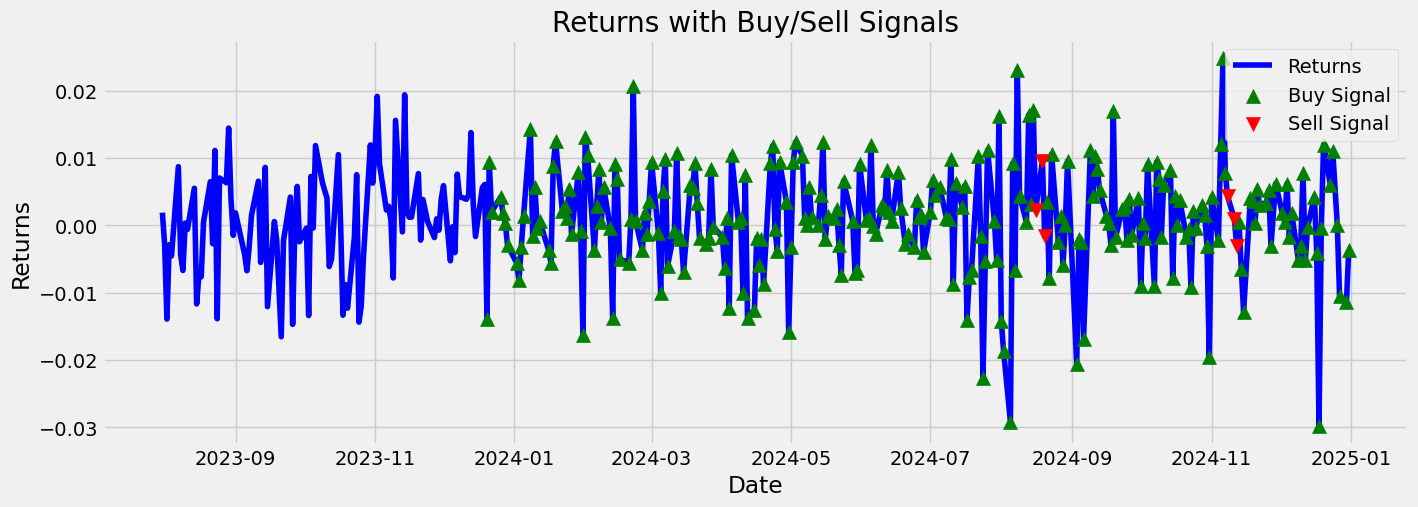

In [62]:
# Create masks for buy and sell signals
buy_mask = test['signal'] == 1
sell_mask = test['signal'] == -1

plt.figure(figsize=(15, 5))

# Plot returns
plt.plot(test.index, test['returns'], label='Returns', color='blue')

# Overlay buy signals
plt.scatter(test.index[buy_mask], test['returns'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)

# Overlay sell signals
plt.scatter(test.index[sell_mask], test['returns'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)

plt.title('Returns with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

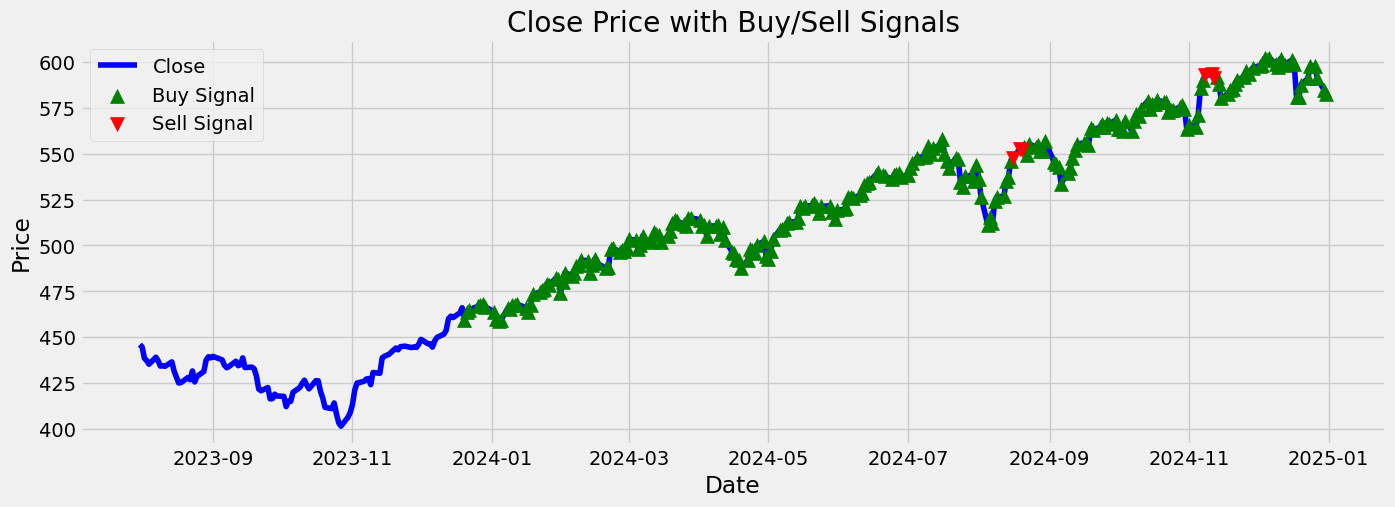

In [64]:
# Create masks for buy and sell signals
buy_mask = test['signal'] == 1
sell_mask = test['signal'] == -1

plt.figure(figsize=(15, 5))

# Plot returns
plt.plot(test.index, test['Close'], label='Close', color='blue')

# Overlay buy signals
plt.scatter(test.index[buy_mask], test['Close'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)

# Overlay sell signals
plt.scatter(test.index[sell_mask], test['Close'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)

plt.title('Close Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Conclusions

It appears that predicting returns is quite tricky. Our true vs predicted returns plots highlight this fact. Despite this, however, the strategy appears to be profitable. Looking again at the 'Close Price with Buy/Sell Signals' graph, we are noticeably lacking any sell signals. Perhaps our strategy is simply benefitting from a bullish year?

In [68]:
print(f'Strategy returns: {test.strategy_returns.iloc[-1]*100: .2f}%')
print(f'{ticker} 2024 returns: {100 * (test.Close.iloc[-1] - test.Close.loc['2024-01-02']) / test.Close.loc['2024-01-02']: .2f}%')

Strategy returns:  20.67%
SPY 2024 returns:  25.59%


Our strategy has slightly underperformed if we had simply bought at the start of the year and held until the end of the year. Whilst it isn't bad, the lack of sell signals isn't filling me with confidence. 

As a next step we will seek to improve our models predictive power. This could be done by including technical indicators such as RSI or EMAs in our feature set, as well as including relevant external data such as VIX statistics and treasury yields.